<a href="https://colab.research.google.com/github/tarabelo/2024-VIU-Quantum/blob/main/Aplicaciones%20pr%C3%A1cticas.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [42]:
# Instalamos qiskit en el notebook
!pip install qiskit qiskit-aer qiskit-algorithms qiskit-optimization qiskit-ibm-runtime pylatexenc

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 167.6/167.6 kB 1.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 635.6/635.6 kB 32.2 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Installing backend dependencies ... done
  Preparing metadata (pyproject.toml) ... done
  Created wheel for docplex: filename=docplex-2.27.239-py3-none-any.whl size=674503 sha256=d21af2818f2f053d8174b774c10de4b95b5345dd0d4c447537563c8833e7b359
  Stored in directory: /root/.cache/pip/wheels/62/7c/db/cef9425e1cedbf45621545097eaaeed5efe07005bd8229dd74
Successfully built docplex


In [2]:
import numpy as np
from math import sqrt

# importing Qiskit
from qiskit import QuantumCircuit, QuantumRegister, ClassicalRegister, transpile
from qiskit_aer import AerSimulator, StatevectorSimulator

# import basic plot tools
from qiskit.visualization import plot_histogram

# Funciones auxiliares

# Función para simular y mostrar el vector de estado
def obten_estado(qcirc, etiqueta="|\psi\!\!> = "):
    # Hacemos una simulación y obtenemos los resultados
    sim = StatevectorSimulator()
    qc_obj = transpile(qcirc, sim)
    result = sim.run(qc_obj).result()
    estado = result.get_statevector()
    display(estado.draw('latex', prefix=etiqueta))

# 5. Aplicaciones prácticas

### Contenidos

1. [Representación de la información](#info)
1. [Problemas de optimización binaria cuadrática sin restricciones (QUBO)](#qubo)
1. [Computación cuántica adiabática y Quantum Annealing](#adiabatica)
1. [Algoritmos cuánticos híbridos](#hibrida)
1. [Quantum Approximate Optimization Algorithm (QAOA)](#qaoa)
1. [Variational Quantum Eigensolvers (VQE)](#vqe)
1. [Quantum Machine Learning](#qml)
1. [Otras aplicaciones](#otras)

<a name="info"></a>
# Representación de la información

Codificar nuestros datos como un estado cuántico: diferentes soluciones propuestas

  - Problema abierto y bajo estudio
  - Dependiente del problema concreto

## Codificación en la base (Basis encoding)

La codificación más simple es usar los cúbits como bits clásicos. Así, por ejemplo, si tenemos 8 cúbits el valor $123$ se representaría como el estado $|01111011\rangle$

También se pueden agrupar los cúbits en _registros_, cada uno con un estado especificando un valor:

$$
\begin{bmatrix}
7\\11
\end{bmatrix} = |0111\rangle|1011\rangle
$$

- Ventajas: el estado es fácil de preparar
- Inconvenientes: necesitamos muchos cúbits

## Codificación en superposición (QuAM encoding)

Alternativamente, un vector de hasta $2^n$ enteros puede ser codificado en estados en superposición de $n$ cúbits.

Por ejemplo con 3 cúbits:

$$
\begin{bmatrix}
1\\3\\5\\6
\end{bmatrix} =
\frac{1}{2}(|001\rangle+|011\rangle + |101\rangle + |110\rangle)
$$

 - Ventajas: se pueden hacer operaciones que afectan a todos los elementos del vector simultáneamente.
 - Inconvenientes: la codificación no puede realizarse de forma eficiente

Un algoritmo para realizar esta codificación se basa en una [memoria cuántica asociativa (QuAM)](https://arxiv.org/abs/quant-ph/9807053)

Ejemplo: prepara el vector $[1,3,5,6]^T$

In [ ]:
a = QuantumRegister(3, name='a')
qc = QuantumCircuit(a)

## Iniciamos el estado
qc.x(a[0])
qc.h(a[1])
qc.h(a[2])
qc.ccx(a[2],a[1],a[0])

display(qc.draw('mpl'))

# Mostramos el vector de estado
obten_estado(qc)

Súmale 1 (módulo 8) a todos los elementos del vector

In [ ]:
a = QuantumRegister(3, name='a')
qc = QuantumCircuit(a)

## Iniciamos el estado
qc.x(a[0])
qc.h(a[1])
qc.h(a[2])
qc.ccx(a[2],a[1],a[0])
qc.barrier()

qc.ccx(a[0],a[1],a[2])
qc.cx(a[0],a[1])
qc.x(a[0])

display(qc.draw('mpl'))

# Mostramos el vector de estado
obten_estado(qc)

## Codificación en amplitud

Un vector de $2^n$ elementos puede ser codificado en las amplitudes de $n$ cúbits.

Restricciones:

1. El número de elementos del vector debe ser potencia de 2
1. El vector debe estar normalizado
1. El proceso de codificación no es trivial

Uso práctico: necesidad de [QRAM](https://en.wikipedia.org/wiki/Quantum_memory)

**Ejemplo**: inicialización de un vector de $2^n$ elementos en un sistema fake de IBMQ:

In [ ]:
n = 4
# Creamos un vector aleatorio de 2**n elementos
v = np.random.random(2**n)
print(v)

In [ ]:
# Normalizamos v
factor = np.sqrt(sum([i*i for i in v]))
vnorm = [i/factor for i in v]
print(sum([i*i for i in vnorm]))

In [ ]:
print(vnorm)

In [ ]:
# Iniciamos un circuito de n cúbits al vector normalizado
qc = QuantumCircuit(n)
qc.initialize(vnorm)
display(qc.draw('mpl'))
obten_estado(qc)

In [ ]:
# Traspilamos a un FakeProvider
from qiskit_ibm_runtime.fake_provider import FakeOsaka
from qiskit.transpiler.preset_passmanagers import generate_preset_pass_manager

fake_backend = FakeOsaka()

# Creamos el Pass manager para ese backend
pass_manager = generate_preset_pass_manager(backend=fake_backend, optimization_level=1)

# Optimiza el circuito usando el pass manager
qc_optimizado = pass_manager.run(qc)

qc_optimizado.draw("mpl", idle_wires=False)

## Codificación en ángulos

Aplicamos a cada cúbit una rotación con un ángulo igual al valor a codificar

  - Necesitamos tantos cúbits como valores a codificar
  - Valores normalizados al intervalo $[-\pi,\pi]$
  - Fácil implementación

In [ ]:
n = 4 # Número de cúbits
v = np.random.random(n)
print(v)

qc = QuantumCircuit(n)
for q in range(n):
    qc.ry(v[q], q)

qc.draw('mpl')

Esta codificación puede complicarse haciendo uso de rotaciones adicionales para codificar $2n$ valores en $n$ cúbits (_dense angle encoding_)

In [ ]:
qc = QuantumCircuit(n/2)
for q in range(0,n,2):
    qc.ry(v[q], q//2)
    qc.p(v[q+1],q//2)

qc.draw('mpl')

Codificaciones de orden más alto (_higher order encoding_) pueden implicar puertas Hadamard, CNOTs entre los cúbits y rotaciones con ángulo producto

  - Pueden ser útiles en determinados problemas

In [ ]:
n = 2 # Número de cúbits
v = [-0.3, 2.5]

qc = QuantumCircuit(n)
qc.h(range(n))
for q in range(n):
    qc.ry(v[q], q)

qc.cx(0,1)
qc.rz(v[0]*v[1], 1)

qc.draw('mpl')

## Codificación de matrices

Una matriz podría codificarse como un conjunto de vectores, pero la forma más habitual es codificarla como una matriz unitaria que se puede usar en algoritmos como el QPE

Sea $A$ una matriz hermítica ($A^\dagger = A$) de coeficientes complejos. Se puede demostrar que la matriz $U = e^{iA}$ es unitaria.

Además, si $U$ es unitaria, existe una matriz hermítica $A$ tal que $U = e^{iA}$.

Podemos codificar una matriz hermítica como una unitaria que se puede usar en nuestro circuito. Si nuestra matriz $A$ no es hermítica, siempre podemos convertirla en hermítica haciendo:

$$A_H=\begin{bmatrix}0 & A\\A^\dagger & 0\end{bmatrix}$$

#### Referencias

- Weigold, M., Barzen, J., Leymann, F., & Salm, M. (2021, March). [Expanding Data Encoding Patterns For Quantum Algorithms](https://www.iaas.uni-stuttgart.de/publications/Weigold2021_ExpandingDataEncodingPatterns.pdf). In 2021 IEEE 18th Int. Conf. on Software Architecture Companion (ICSA-C) (pp. 95-101).
- LaRose, R., & Coyle, B. (2020). [Robust data encodings for quantum classifiers](https://link.aps.org/pdf/10.1103/PhysRevA.102.032420). Physical Review A, 102(3), 032420.



---



---



---



<a name="qubo"></a>
# Problemas de optimización binaria cuadrática sin restricciones (QUBO)

Un tipo de problemas en los que se está usando la computación cuántica son los denominados [QUBO](https://en.wikipedia.org/wiki/Quadratic_unconstrained_binary_optimization) (_Quadratic Unconstrained Binary Optimization_).

Este tipo de problemas consisten en minimizar (o maximizar) una función $f_Q(x)$ con la siguiente forma:

$$f_Q(x) = \sum_{i=1}^n\sum_{j=1}^i q_{ij}x_ix_j$$

donde $Q$ es una matriz triangular de coeficiente $q_{ij}\in \mathbb{R}$ y $x_i \in \{0,1\}$.

Los problemas QUBO son [NP-duros](https://es.wikipedia.org/wiki/NP-hard).

Muchos modelos de optimización combinatoria pueden expresarse como problemas QUBO, por ejemplo modelos de programación lineal o problemas como el coloreado de grafos o el problema del viajante.

### Ejemplo: algoritmo MAX-CUT

Sea $G = (V, E)$ un grafo pesado no dirigido con $n$-nodos y pesos $w_{ij}>0$, $w_{ij}=w_{ji}$, con $(j,k)\in E$ y $w_{ij}=0$ si $(j,k)\notin E$.

Objetivo: dividir el grafo en dos conjuntos tal que la suma de los pesos de las aristas entre ambos conjuntos sea máximo.

<center><img src="https://drive.google.com/uc?export=view&id=15ZhQCZB3k5SJzpQHyYLWCflUSS3js75g" alt="Ejemplo MAX-CUT" width="700"  /></center>

El algoritmo procede asignando a cada vértice un valor $x_i = \{0,1\}$ de forma que el grafo queda dividido en dos conjuntos: los vértices con $x_i = 0$ y aquellos con $x_i = 1$.

El algoritmo MAX-CUT busca el número binario $\textbf{x}=x_1\cdots x_n$ que maximice la función de coste:

$$
C(\textbf{x}) = \sum_{i,j = 0}^{n-1} w_{ij} x_i (1-x_j)
$$

Si los vértices $i$ y $j$ están en el mismo conjunto: $x_i = x_j \Rightarrow x_i (1-x_j) = 0$.

Si los vértices $i$ y $j$ están en diferentes conjunto: $x_i \ne x_j \Rightarrow x_i (1-x_j) = 1$ ó $x_j (1-x_i) = 1$.

Así, $C(\textbf{x})$ es la suma de los pesos de las aristas que separan ambos conjuntos.

### Modelo Ising

El algoritmo MAX-CUT se puede expresar como un problema de minimización equivalente al anterior:

\begin{align*}
\mathrm{Minimiza}\quad & C(\textbf{z}) = \sum_{(i,j) \in E} w_{ij} z_i z_j \\
\mathrm{con}\quad & z_i = \{-1,1\}, i = 0\ldots n-1
\end{align*}

Esta formulación puede verse como un caso particular de un problema de física estadística denominado [_modelo Ising_](https://en.wikipedia.org/wiki/Ising_model) que estudia el comportamiento de materiales ferromagnéticos.

Este modelo parte de una malla de $n$ partículas y busca minimizar la siguiente función:

$$H(\textbf{z}) = -\sum_{i,j = 0,i<j}^{n-1} J_{ij}z_iz_j -\sum_{i = 0}^{n-1} h_i z_i$$

donde $z_i = \{-1,1\}$ representa el espín de la partícula $i$, $J_{ij}$ la energía de interacción entre dos partículas y $h_i$ la influencia de un campo magnético externo.

$H(\textbf{z})$ se denomina **función Hamiltoniana** y representa la energía del sistema. Resolver el problema permite obtener la configuración de espines correspondiente a un estado de mínima energía (o estado base).

**Ejemplo**:

<center><img src="https://drive.google.com/uc?export=view&id=17aVy149zEGw2L8efKnDpthUo9hstOsBK" alt="Malla Ising" width="500"  /></center>

En esta malla, suponiendo que $h_i=1, \forall{i}$, el Hamiltoniano resulta:

$$
H(\textbf{z}) = z_0z_1-3z_1z_2+z_2z_3-2z_0z_4+z_1z_5-3z_2z_6-2z_3z_7\\
+z_4z_5+z_5z_6+z_6z_7+z_4z_8-3z_5z_9+z_6z_{10}-z_7z_{11}\\
+z_8z_9-2z_9z_{10}+2z_{10}z_{11}-z_0-z_1-z_2-z_3-z_4-z_5\\
-z_6-z_7-z_8-z_9-z_{10}-z_{11}
$$

con $z_i = \{-1,1\}, \forall i$

Es posible demostrar que cualquier problema QUBO puede expresarse como un modelo Ising de forma simple. Resolver este modelo es la base de la **computación cuántica adiabática** y de algoritmos como el QAOA.

Adicionalmente, es posible demostrar que es posible transformar muchos problemas de optimización combinatoria con restricciones a un problema QUBO.

### Ejemplo: MAX-CUT

Veamos un caso muy simple de algoritmo MAX-CUT con el siguiente grafo de 3 nodos sin pesos:

<center><img src="https://drive.google.com/uc?export=view&id=1FicH0ZeqsAhjOqOSfJq_MDYaW6ASTjBs" alt="Grafo simple" width="150"  /></center>

En este caso, el problema se reduce al siguiente:

\begin{align*}
\text{Minimiza}\quad & z_0 z_1 + z_0z_2 \\
\text{con}\quad & z_i = \{-1,1\}, i = 0,1,2
\end{align*}

Supongamos un sistema de 3 cúbits en un estado base $|x\rangle = |x_2x_1x_0\rangle \in \{000,001,\ldots,111\}$. Podemos usar cada uno de estos estados para representar un *corte* en el grafo.

Además, para la puerta $Z$ se verifica que valores esperados en los estados $|0\rangle$ y $|1\rangle$ son::

$$
\begin{aligned}
\langle 0|Z|0\rangle &= \begin{bmatrix}1 & 0\end{bmatrix}\begin{bmatrix}1 & 0\\0 & -1\end{bmatrix}\begin{bmatrix}1 \\ 0\end{bmatrix} = 1\\
\langle 1|Z|1\rangle &= \begin{bmatrix}0 & 1\end{bmatrix}\begin{bmatrix}1 & 0\\0 & -1\end{bmatrix}\begin{bmatrix}0 \\ 1\end{bmatrix} = -1
\end{aligned}
$$

por lo que podemos usar esos valores para representar las $z_i$.

Para una arista $(j,k)\in E$ del grafo vamos a denotar $Z_jZ_k$ como la aplicación de una puerta $Z$ a los cúbits $j$ y $k$, aplicando la identidad al resto. Así, para la arista $(1,0)$:

$$Z_1Z_0 = I\otimes Z\otimes Z$$

Dado un estado base $|x\rangle = |x_2x_1x_0\rangle$ tenemos:

$$
\langle x|Z_1Z_0|x\rangle = \langle x_2x_1x_0|I\otimes Z\otimes Z|x_2x_1x_0\rangle =
\langle x_2|I|x_2\rangle\langle x_1|Z|x_1\rangle\langle x_0|Z|x_0\rangle = \langle x_1|Z|x_1\rangle\langle x_0|Z|x_0\rangle
$$

Y como los $x_i \in \{0,1\}$, dados los valores esperados de $Z$ podemos escribir:

\begin{gather*}
\langle x|Z_1Z_0|x\rangle =     
\begin{cases}
  1 & \text{sí }x_1=x_0 \text{ (vértices 1 y 0 en el mismo conjunto)}\\    
  -1 & \text{sí }x_1\ne x_0 \text{ (vértices 1 y 0 en diferentes conjunto)}
\end{cases}
\end{gather*}

Considerando las dos aristas del grafo, la solución al problema es el estado $|x\rangle$ que minimize:

$$\langle x|Z_1Z_0|x\rangle+\langle x|Z_2Z_0|x\rangle = \langle x|Z_1Z_0+Z_2Z_0|x\rangle = \langle x|\sum_{(j,k)\in E}Z_jZ_k|x\rangle$$

El operador $H = Z_1Z_0+Z_2Z_0$ para el que obtenemos el valor estimado se denomina **Hamiltoniano** del problema. Para resolver el MAX-CUT tenemos que buscar el estado de la base $|x\rangle$ que minimize el valor esperado de ese operador.

#### Ejemplo:

Corte $\{010\}$:

$$
\langle 010|Z_1Z_0|010\rangle+\langle 010|Z_2Z_0|010\rangle = \langle 1|Z_1|1\rangle\langle 0|Z_0|0\rangle +
 \langle 0|Z_2|0\rangle\langle 0|Z_0|0\rangle = -1 + 1 = 0
$$

Corte $\{110\}$:

$$
\langle 110|Z_1Z_0|110\rangle+\langle 110|Z_2Z_0|110\rangle = \langle 1|Z_1|1\rangle\langle 0|Z_0|0\rangle +
 \langle 1|Z_2|1\rangle\langle 0|Z_0|0\rangle = -1 - 1 = -2
$$

Este segundo corte es la solución del problema.

#### Obtención del valor esperado en Qiskit

Obten el valor estimado del operador $Z_1Z_0+Z_2Z_0$ para todos los estados de la base canónica de 3 cúbits.



In [31]:
from qiskit.quantum_info import Pauli, SparsePauliOp

n = 3

# Definimos el operador hamiltoniano
Z1Z0 = Pauli('IZZ')
Z2Z0 = Pauli('ZIZ')

operador = SparsePauliOp(Z1Z0)+SparsePauliOp(Z2Z0)

print(operador)

SparsePauliOp(['IZZ', 'ZIZ'],
              coeffs=[1.+0.j, 1.+0.j])


In [4]:
from qiskit.quantum_info import Statevector

# Creamos una lista con todos los estados base para n cúbits

estados = [Statevector.from_int(i, dims=2**n) for i in range(2**n)]

for i in range(2**n):
  print('Estado ',i, 'valor esperado=',estados[i].expectation_value(operador).real)

Estado  0 valor esperado= 2.0
Estado  1 valor esperado= -2.0
Estado  2 valor esperado= 0.0
Estado  3 valor esperado= 0.0
Estado  4 valor esperado= 0.0
Estado  5 valor esperado= 0.0
Estado  6 valor esperado= -2.0
Estado  7 valor esperado= 2.0


#### Generalización del MAX-CUT

Es fácil generalizar el problema del MAX-CUT con n nodos a encontrar el estado $|\psi\rangle$ de n cúbits que minimize:

$$
\langle \psi|\sum_{(j,k)\in E}Z_jZ_k|\psi\rangle
$$


La expresión $\langle \psi|\sum_{(j,k)\in E}Z_jZ_k|\psi\rangle = \sum_{(j,k)\in E} \langle \psi|Z_jZ_k|\psi\rangle$ es el valor esperado del operador $\sum_{(j,k)\in E}Z_jZ_k$ en el estado $|\psi\rangle$.

El hamiltoniano $H = \sum_{i,j=0}^{n-1}Z_iZ_j$ es hermitiano ($H = H^\dagger$).


#### Problema Ising
En el caso más general de un problema Ising, este se puede expresar como:

\begin{align*}
\qquad\underset{|\psi\rangle}{\text{Minimizar}}\quad & -\sum_{i,j=0}^{n-1} J_{ij}\langle \psi|Z_iZ_j|\psi\rangle - \sum_{i=0}^{n-1} h_{i}\langle \psi|Z_i|\psi\rangle \\
\text{siendo}\quad & |\psi\rangle \text{ un estado cuántico de n cubits}
\end{align*}



Resolver el problema Ising implica entonces encontrar el estado cuántico correspondiente al mínimo de ese Hamiltoniano. Ese estado se denomina estado-base o **ground-state**.

#### Resumen

Pasos para resolver en un computador cuántico un problema de optimización:

1. Expresar el problema usando el formalismo QUBO
2. Convertir en problema QUBO en un problema Ising
3. Resolver el problema Isisng usando computación cuántica adiabática o el algoritmo QAOA




---



---



---



<a name="adiabatica"></a>
# Computación cuántica adiabática y Quantum Annealing

## Computación cuántica adiabática

Forma alternativa de computación cuántica basada en la evolución temporal de un Hamiltoniano y en el [teorema adiabático](https://en.wikipedia.org/wiki/Adiabatic_theorem)

#### Ecuación de Schrödinger

La evolución temporal de un sistema cuántico viene dada por la ecuación de Schrödinger:

$$i\hbar \frac{\partial}{\partial t}|\psi(t)\rangle = H(t)|\psi(t)\rangle$$

$H(t)$ es el Hamiltoniano del sistema en el instante $t$ y define la energía del mismo.

#### Teorema adiabático
Si un sistema cuántico está en un estado base (estado de menor energía o _ground state_) de un Hamiltoniano inicial y se le hace evolucionar muy lentamente hacia un Hamiltoniano final, este estado inicial evolucionará al estado base del Hamiltoniano final, tras un tiempo suficientemente largo.

Supongamos que tenemos un Hamiltoniano $H_c$ (_Hamiltoniano de coste_) cuyo estado base codifica la solución de nuestro problema.

Partimos de un Hamiltoniano $H_0$ cuyo estado base es facil de preparar y queremos llegar, en un tiempo $T$, al estado base de $H_c$. Hacemos evolucionar el sistema desde $t=0$ hasta $t=T$ como sigue:

$$H(t) = A(t)H_0 + B(t)H_c$$

donde las funciones $A$ y $B$ verifican: $A(0) = B(T) = 1$ y $A(T) = B(0) = 0$.

Un ejemplo de estas funciones son

$$
A(t) =  \left(1-\frac{t}{T}\right)\\
B(t) = \frac{t}{T}
$$


Si $t$ cambia muy lentamente, el sistema pasa de $H(0) = H_0$ a $H(T) = H_c$ manteniéndose en el estado base.

Midiendo el estado del sistema en $t=T$ obtenemos el estado $|\psi\rangle$ que minimiza $\langle\psi|H_c|\psi\rangle$ y que es la solución del problema.

En [Aharonov et al. 2007](https://doi.org/10.1137/080734479) se demostró que la computación cuántica adiabática es equivalente a la computación cuántica basada en puertas.

#### Tiempo de evolución

El teorema adiabático establece que para que $H(t)$ se mantenga en el estado base, $T$ tiene que ser inversamente proporcional al cuadrado del *spectral gap* (minima diferencia de energía entre el estado base y el primer estado excitado de $H(t)$ con $t\in[0,T]$).

Encontrar el valor del *spectral gap* es muy complejo. Además, $T$ podría llegar a ser muy grande. El *Quantum annealing* es una implementación práctica de la computación cuántica adiabática.


### Quantum annealing

Es un modelo similar a la computación cuántica adiabática, con ciertas limitaciones:

- El Hamiltoniano final tiene que ser un Hamiltoniano Ising:  

$$
H_c = -\sum_{i,j=0}^{n-1} J_{ij}Z_iZ_j - \sum_{i=0}^{n-1} h_{i}Z_i
$$

- No se mantiene la evolución adiabática $\implies$ el estado final podría no ser el estado base de $H_c$

**Estado inicial $H_0$**

Se suele usar como estado inicial el siguiente:

$$
H_0 = -\sum_{i=0}^{n-1} X_i
$$

Este estado se denomina _mixing Hamiltonian_ y su estado base es $|\psi_0\rangle = |+\rangle^{\otimes n}$

**Evolución del Hamiltoniano**

La evolución viene dada por:

$$
H(t) = A(t)H_0 + B(t)H_c = -A(t)\sum_{i=0}^{n-1} X_i - B(t)\sum_{i,j=0}^{n-1} J_{ij}Z_iZ_j - B(t)\sum_{i=0}^{n-1} h_{i}Z_i
$$


#### Quantum annealers
Computadores cuánticos que resuelven problemas de optimización mediante Quantum annealing.

- [D-Wave Systems](https://www.dwavesys.com/): Primera empresa en vender quantum annealers
  - El último modelo dispone de más de 5000 cúbits
  - Suite [Ocean](https://docs.ocean.dwavesys.com/en/latest/)
  - Tipo de problemas: optimización de portfolios, optimización de rutas y gestión de flotas, optimización de líneas de producción, búsqueda de similaridad entre moléculas, etc.


### Discretización de la evolución adiabática (*Trotterization*)

Podemos replicar la evolución adiabática en un computador cuántico basado en puertas discretizando la evolución continua del Hamiltoniano.

La evolución temporal de un sistema viene dada por la ecuación de Schrödinger:

$$i\hbar \frac{d}{dt}|\psi(t)\rangle = H(t)|\psi(t)\rangle$$

En general, $H(t)$ depende del tiempo. Pero en un intervalo temporal $[t_i, t_i+\Delta t]$ suficientemente pequeño, podemos considerar $H(t_i)$ constante, verificándose que:

$$|\psi(t_i+\Delta t)\rangle = e^{-iH(t_i)\Delta t}|\psi(t_i)\rangle = U_i|\psi(t_i)\rangle$$

siendo $U_i = e^{-iH(t_i)\Delta t}$ una matriz unitaria.



Si discretizamos la evolución en $p = \frac{T}{\Delta t}$ pasos, podemos escribir:

$$
|\psi(t_1)\rangle = U_1|\psi(t_0)\rangle \\
|\psi(t_2)\rangle = U_2|\psi(t_1)\rangle \\
\cdots \\
|\psi(t_{p-1})\rangle = U_{p-1}|\psi(t_{p-2})\rangle
$$


De esta forma, el estado final del sistema puede aproximarse por:

$$
|\psi(T)\rangle = U_{p-1}U_{p-2}\cdots U_{1}U_{0}|\psi(t_0)\rangle = \left(\prod_{m=p-1}^{0} U_m\right) |\psi(0)\rangle =
$$

El Hamiltoniano usado en computación adiabática es:

$$H(t) = A(t)H_0 + B(t)H_c$$

por lo que resulta:

$$
|\psi(T)\rangle = \left(\prod_{m=0}^{p-1} e^{i\Delta t(A'(t_m)H_0 + B'(t_m)H_c)}\right) |\psi(0)\rangle
$$

donde $A'(t_m) = -A(t_{p-1-m})$, $B'(t_m) = -B(t_{p-1-m})$, $|\psi(T)\rangle = |\psi(t_{p-1})\rangle$ y $|\psi(0)\rangle = |\psi(t_{0})\rangle$

En general, dadas dos matrices $A$ y $B$, la igualdad $e^{A+B} = e^Ae^B$ solo se da si $A$ y $B$ _conmutan_, es decir si $[A,B] = AB-BA = 0$. sin embargo, si $\Delta t$ es lo suficientemente pequeño, la formula de Lie-Trotter permite escribir:

$$
e^{i\Delta t(A'(t_m)H_0 + B'(t_m)H_c)} \approx e^{i\Delta tA'(t_m)H_0} e^{i\Delta tB'(t_m)H_c}
$$

Por lo tanto, el estado final del sistema se puede escribir:

$$
|\psi_f\rangle = |\psi(T)\rangle = \left(\prod_{m=0}^{p-1} e^{i\Delta tA'(t_m)H_0} e^{i\Delta tB'(t_m)H_c}\right) |\psi(0)\rangle =
\prod_{m=0}^{p-1} U_0(t_m)U_c(t_m)|\psi_0\rangle
$$

siendo las matrices unitarias:

$$
U_0(t_m) = e^{i\Delta tA'(t_m)H_0}\\
U_c(t_m) = e^{i\Delta tB'(t_m)H_c}
$$

Este procedimiento se denomina _trotterization_ y es la base de algoritmos como el QAOA.




---



---



---



<a name="hibrida"></a>
# Algoritmos cuánticos híbridos

Problema de los computadores cuánticos actuales: el ruído destruye la superposición de estado.

No es posible resolver un problema complejo (profundo) en un sistema actual: por ejemplo, la factorización de Shor podría necesitar millones de cúbits para corrección de errores.

Computadores actuales: _Noisy intermediate-scale quantum_ (NISQ)

Podemos pensar en dividir un problema complejo en partes más simples, y utilizar CPUs tradicionales en el proceso de optimización:

<center><img src="https://drive.google.com/uc?export=view&id=1WgpYw-cCkpuNZE2AOnPL4b3kIt9A_kU2" alt="Algoritmo híbrido" width="700"  /></center>

Esta estrategia también se denomina _Computación variacional_.

Se basa en usar un circuito cuántico que incluye parámetros que se van optimizando. Este circuitos se  denomina *ansatz*, _forma (o circuito) variacional_ o, simplemente, circuito cuántico parametrizado.

### Circuitos parametrizados en Qiskit

Qiskit incluye métodos para facilitar la creación de circuitos parametrizados.

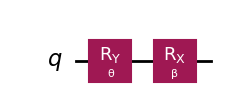

In [5]:
from qiskit.circuit import Parameter, ParameterVector

#Se crean los parámetros usando un string como identificador (no se les asignan ningún valor)
parameter_0 = Parameter('θ')
parameter_1 = Parameter('β')
circuit = QuantumCircuit(1)

#Podemos ahora usar los parámetros como ángulos de rotación en una puerta
circuit.ry(theta = parameter_0, qubit = 0)
circuit.rx(theta = parameter_1, qubit = 0)

circuit.draw('mpl')

Es posible definir vectores de parámetros

In [ ]:
# Numero de cubits y de parametros
n = 2
num_par = 2*n

# ParameterVectors se inicializan con un identificador y un entero que indica la longitud del string
parameters = ParameterVector('θ', num_par)

circuit = QuantumCircuit(n)

for i in range(n):
    circuit.ry(parameters[i], i)
    circuit.rx(parameters[i+n], i)

circuit.draw('mpl')

Finalmente, se dan valores a los parámetros.

In [ ]:
# Creamos un diccionario que asigna a cada parámetro un valor aleatorio
param_dict = {p: np.random.random() for p in parameters}
print(param_dict)

# El método assign_parameters permite ligar los valores al circuito
circuit_v = circuit.assign_parameters(parameters = param_dict)
circuit_v.draw('mpl')

-------------------

## Ejercicio 5.1

Crea el siguiente circuito parametrizado, que alterna capas de rotaciones $R_y$ con CNOTS. Esta forma variacional se denomina [RealAmplitudes](https://qiskit.org/documentation/stubs/qiskit.circuit.library.RealAmplitudes.html) y se usa en química computacional y en problemas de clasificación en quantum machine learning.

<center><img src="https://drive.google.com/uc?export=view&id=1HKVx-jEzWhNPH-VNEpzATRyv0xG0fFfZ" alt="Ansatz Real Amplitudes" width="700"  /></center>


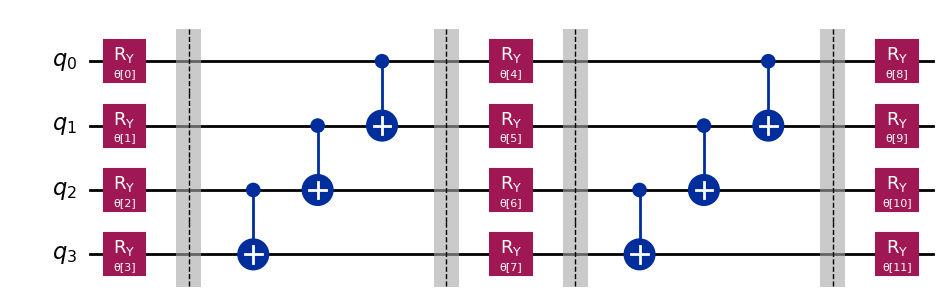

In [7]:
from qiskit.circuit import Parameter, ParameterVector

# Número de cubits y capas Ry+CNOT (no cuenta la capa Ry final)
n = 4
num_layers = 2

# Crea el vector de parámetros
parameters = ParameterVector('θ', n*(num_layers+1))

# Crea el circuito
circuit = QuantumCircuit(n)

# Crea las capas Ry+CNOT
for layer in range(num_layers):
    #
    # TODO: Añade las puertas Ry parametrizadas usando el vector de parámetros para obtener el estado 𝜓0
    #
    for i in range(n):
        circuit.ry(parameters[n*layer+i], i)


    # Barrera para visualización
    circuit.barrier()

    #
    # TODO: Añade las puertas CNOT
    #
    for i in range(n-1,0,-1):
        circuit.cx(i-1,i)


    # Barrera para visualización
    circuit.barrier()

#
# Añade la capa Ry final
#
for i in range(n):
    circuit.ry(parameters[n*num_layers+i], i)

circuit.draw('mpl')

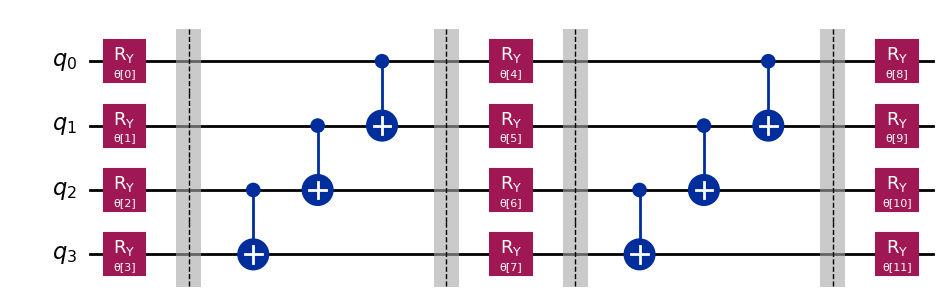

In [8]:
# Este circuito está implementado en la librería de Qiskit
from qiskit.circuit.library import RealAmplitudes
ansatz = RealAmplitudes(n, reps=num_layers, insert_barriers=True)
ansatz.decompose().draw('mpl')



---



---



---



<a name="qaoa"></a>
# Quantum Approximate Optimization Algorithm (QAOA)

Algoritmo híbrido basado en la discretización de la evolución adiabática para resolver problemas Ising.

Como ya hemos visto, el estado final del sistema despues de la evolución es:

$$
|\psi_f\rangle = |\psi(T)\rangle = \left(\prod_{m=1}^p e^{i\Delta tA'(t_m)H_0} e^{i\Delta tB'(t_m)H_c}\right) |\psi(0)\rangle =
\prod_{m=0}^{p-1} U_0(t_m)U_c(t_m)|\psi_0\rangle
$$

siendo las matrices unitarias:

$$
U_0(t_m) = e^{i\Delta tA'(t_m)H_0} = e^{i\beta_mH_0} = U_0(\beta_m)\\
U_c(t_m) = e^{i\Delta tB'(t_m)H_c} = e^{i\gamma_mH_c} = U_c(\gamma_m)
$$
con $m=0,\ldots,p-1$ y $p \ge 1$.

QAOA intenta elegir unos valores de $\beta_m$ y $\gamma_m$ que aproximen el estado $|\psi_f\rangle$ al estado base del Hamiltoniano de coste $H_c$, es decir, que minimizen $\langle\psi_f|H_c|\psi_f\rangle$.

El algoritmo QAOA parte de un Hamiltoniano de coste $H_c$ que define el problema y procede como sigue:

1. Se elige un valor de $p\ge 1$ y dos listas de valores $\boldsymbol{\beta} = (\beta_0,\ldots,\beta_{p-1})$ y $\boldsymbol{\gamma} = (\gamma_0,\ldots,\gamma_{p-1})$
1. Como $H_0$ se suele usar el _mixing Hamiltonian_ y como estado inicial se suele usar la superposición completa
  $$H_0 = -\sum_{i=0}^{n-1} X_i\quad
  |\psi_0\rangle = |+\rangle^{\otimes n}$$
2. La QPU aplica las puertas $U_0(\beta_m)U_c(\gamma_m)$, $m=0,\ldots,p-1$, y se obtiene un nuevo estado $|\psi_p\rangle$
3. En la CPU se usa un algoritmo de optimización para actualizar los parámetros $\boldsymbol{\beta}$ y $\boldsymbol{\gamma}$ intentando minimizar el valor esperado $\langle\psi_p|H_c|\psi_p\rangle$
4. Se vuelve al paso 2 hasta obtener los valores óptimos $\boldsymbol{\beta}^\ast$ y $\boldsymbol{\gamma}^\ast$
5. Usando esos valores, se obtiene el estado que minimiza la solución

El proceso de optimización de los parámetros puede ser un simple gradiente descendente, en el que cada parámetro se actualiza en la dirección que conduzca al mayor descenso del valor esperado, u otros método de optimización más sofisticados.

### Construcción de $U_0(\beta)$ y $U_c(\gamma)$

#### Puertas para $U_0(\beta)$

Si tenemos $n$ cúbits, y dado que las matrices $X$ conmutan tenemos:

$$U_0(\beta) = e^{i\beta H_0} = e^{-i\beta\sum_{i=0}^{n-1} X_i} = \prod_{i=0}^{n-1}e^{-i\beta X_i}$$

Y recordando que la puerta de rotación $R_x(\theta) = e^{-i\theta X/2}$, se tiene:

$$U_0(\beta) = \prod_{i=0}^{n-1} R_x^{(i)}(2\beta)$$

La puerta $R_x^{(i)}$ indica que se aplica una $R_x$ al cúbit $i$ y la identidad al resto $\implies$ el producto equivale a aplicar una puerta $R_x(2\beta)$ a cada uno de los cúbits.

#### Puertas para $U_c(\gamma)$

El Hamiltoniano de coste de un problema Ising es:


$$H_c = -\sum_{i,j = 0}^{n-1} J_{ij}Z_iZ_j -\sum_{i = 0}^{n-1} h_i Z_i$$

siendo $J_{ij}$ y $h_i$ números reales.

Ya que las matricez $Z$ conmutan, podemos escribir

$$
U_c(\gamma) = e^{i\gamma H_c} = e^{-i\gamma(\sum_{i,j = 0}^{n-1} J_{ij}Z_iZ_j +\sum_{i = 0}^{n-1} h_i Z_i)} =
\prod_{i,j = 0}^{n-1}e^{-i\gamma J_{ij}Z_iZ_j}\prod_{i=0}^{n-1}e^{-i\gamma h_i Z_i}
$$

El segundo término se puede implementar con puertas $R_z(\theta) = e^{-i\theta Z/2}$.


Para el primer término, $Z_iZ_j$ representa aplicar una puerta $Z$ a los cúbits $i$ y $j$ y la identidad al resto:

$$
Z_iZ_j = I\otimes\ldots\otimes Z\otimes\ldots\otimes Z \otimes\ldots I = Z_i\otimes Z_j
$$

Y el término $e^{-i\gamma J_{ij}Z_i\otimes Z_j}$ corresponde a una [puerta Ising ZZ](https://qiskit.org/documentation/stubs/qiskit.circuit.library.RZZGate.html#qiskit.circuit.library.RZZGate) entre los cúbits $i$ y $j$:

$$
R_{ZZ}(\theta) = \exp\left(-i\frac{\theta}{2}(Z\otimes Z)\right) =
\exp{\left(-i\frac{\theta}{2}\begin{bmatrix}
1 & 0 & 0 & 0\\
0 & -1 & 0 & 0\\
0 & 0 & -1 & 0\\
0 & 0 & 0 & 1\\
\end{bmatrix} \right)}=
\begin{bmatrix}
e^{-i\theta/2} & 0 & 0 & 0\\
0 & e^{i\theta/2} & 0 & 0\\
0 & 0 & e^{i\theta/2} & 0\\
0 & 0 & 0 & e^{-i\theta/2}\\
\end{bmatrix}
$$

Con lo que queda:

$$
U_c(\gamma) = \prod_{i,j = 0}^{n-1} R_{ZZ}^{(i,j)}(2\gamma J_{ij})\prod_{i=0}^{n-1}R_z^{(i)}(2\gamma h_i)
$$


In [ ]:
from qiskit.circuit import Parameter

# Puerta ZZ en Qiskit
theta = Parameter('θ')
qc = QuantumCircuit(2)

qc.rzz(theta, 0, 1)

display(qc.draw('mpl'))

display(qc.decompose().draw('mpl'))

### Ejemplo

Obtener el circuito QAOA para un paso ($p$=1) del Hamiltoniano Ising:

$$
H_c = 3Z_2Z_0 - Z_2Z_1 + 2Z_0
$$

Necesitamos 3 cúbits, y el estado que queremos conseguir será:

$$
U_0(\beta)U_c(\gamma) |+\rangle^{\otimes 3}
$$

Con

$$
U_0(\beta) = \prod_{i=0}^{2} R_x^{(i)}(2\beta) = R_x^{(0)}(2\beta)\otimes R_x^{(1)}(2\beta)\otimes R_x^{(2)}(2\beta)
$$

$$
U_c(\gamma) = \prod_{i,j = 0}^{2} R_{ZZ}^{(i,j)}(2\gamma J_{ij})\prod_{i=0}^{2}R_z^{(i)}(2\gamma h_i) = (R_{ZZ}^{(2,0)}(6\gamma)\otimes R_{ZZ}^{(2,1)}(-2\gamma))(R_z^{(0)}(4\gamma))
$$

El circuito sería:

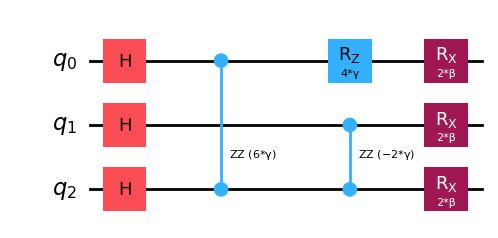

In [35]:
from qiskit.circuit import Parameter

n = 3

beta = Parameter('β')
gamma = Parameter('γ')

qc = QuantumCircuit(n)

# Estado superpuesto
qc.h(range(3))

# Puertas U_c
qc.rzz(6*gamma, 2, 0)
qc.rzz(-2*gamma, 2, 1)
qc.rz(4*gamma, 0)

# puertas U_0
for i in range(3):
    qc.rx(2*beta, i)

qc.draw('mpl')

Podemos usar la implementación de QAOA de Qiskit para obtener este mismo circuito

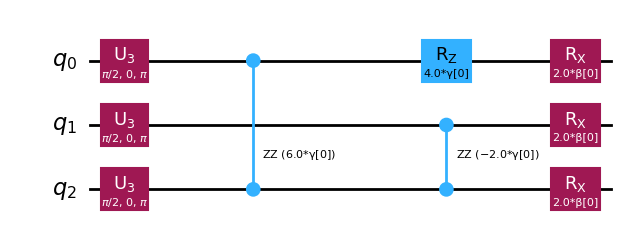

In [36]:
from qiskit.circuit.library import QAOAAnsatz
from qiskit.quantum_info import SparsePauliOp

# Expresamos el problema como un operador Hamiltoniano
Hc = SparsePauliOp.from_list([("ZIZ", 3), ("ZZI", -1), ("IIZ", 2)])

# Creamos el ansatz QAOA
ansatz = QAOAAnsatz(Hc, reps=1)

ansatz.decompose(reps=3).draw("mpl")

Encontramos por fuerza bruta los valores esperados para los estados base:

In [37]:
from qiskit.quantum_info import Statevector

# Creamos una lista con todos los estados base para n cúbits
estados = [Statevector.from_int(i, dims=2**n) for i in range(2**n)]

for i in range(2**n):
  print('Estado ',i, 'valor esperado=',estados[i].expectation_value(Hc).real)

Estado  0 valor esperado= 4.0
Estado  1 valor esperado= -6.0
Estado  2 valor esperado= 6.0
Estado  3 valor esperado= -4.0
Estado  4 valor esperado= 0.0
Estado  5 valor esperado= 2.0
Estado  6 valor esperado= -2.0
Estado  7 valor esperado= 0.0


Usamos la implementación de [QAOA](https://qiskit-community.github.io/qiskit-algorithms/stubs/qiskit_algorithms.QAOA.html) del paquete [qiskit_algorithms](https://qiskit-community.github.io/qiskit-algorithms/apidocs/qiskit_algorithms.html) para obtener el mínimo

In [40]:
from qiskit_algorithms import QAOA
from qiskit_algorithms.optimizers import COBYLA
from qiskit.primitives import Sampler
from qiskit_algorithms.utils import algorithm_globals
from qiskit.result import QuasiDistribution

# Sampler: nueva primitiva de Qiskit que obtiene
# muestras del circuito para estimar el valor esperado.
sampler = Sampler()

algorithm_globals.random_seed = 10598

optimizer = COBYLA()

qaoa = QAOA(sampler, optimizer)

# Obtiene el mínimo autovalor del Hamiltoniano
result = qaoa.compute_minimum_eigenvalue(Hc)

print(result,'\n')

bistring = result.best_measurement['bitstring']
valor = result.best_measurement['value']
print("Estado que minimiza Hc = {}".format(bistring))
print("Valor esperado <{}|Hc|{}> = {}".format(bistring,bistring,valor.real))

{   'aux_operators_evaluated': None,
    'best_measurement': {   'bitstring': '001',
                            'probability': 0.31123958662106,
                            'state': 1,
                            'value': (-6+0j)},
    'cost_function_evals': 39,
    'eigenstate': {0: 0.004466231526623, 1: 0.310145061660666, 2: 0.00300456139432, 3: 0.182384145418392, 4: 0.156792782329545, 5: 0.028595924483166, 6: 0.221694403472122, 7: 0.092916889715166},
    'eigenvalue': -2.9407116151430666,
    'optimal_circuit': <qiskit.circuit.quantumcircuit.QuantumCircuit object at 0x799f7e7351b0>,
    'optimal_parameters': {   ParameterVectorElement(β[0]): -0.4136980759016128,
                              ParameterVectorElement(γ[0]): -6.10272340437534},
    'optimal_point': array([-0.41369808, -6.1027234 ]),
    'optimal_value': -2.9407116151430666,
    'optimizer_evals': None,
    'optimizer_result': <qiskit_algorithms.optimizers.optimizer.OptimizerResult object at 0x799f7ddf0730>,
    'optimi

## Programas cuadráticos con restricciones cuadráticas

Un programa cuadrático con restricciones cuadráticas (_Quadratically Constrained Quadratic Program_, QCQP) es un problema de optimización con una función objetivo cuadrática y restricciones cuadráticas. Se puede escribir como:
$$
\begin{align}
\text{minimizar} &&x^T Q x + c^T x &&\\
&& && \\
\text{sujeto a} &&Ax \leq b  &&\\
&& x^TQ_ix + a_i^Tx \leq r_i \\
&& l_j \leq x_j \leq u_j \\
\end{align}
$$
donde $Q \in \mathbb{R}^{n \times n}$ y $c \in \mathbb{R}^n$ y las variables a optimizar, $x_i, i \in \{1, \dots, n\}$, pueden ser binarias, enteras o reales (en la versión actual de Qiskit, las variables continuas no están soportadas).

**Ejemplo**

Minimiza $y=10x_0+20x_1+30 x_2 +  4 x_0x_1 + 2 x_0x_2 + 6 x_1x_2 + 4 x_1^2  + 2 x_2^2$

con las siguientes restricciones:

  - $x_0\in\{0,1\}$
  - $x_1, x_2 \in \mathbb{Z}, -1\le x_1 \le 1, -2\le x_2 \le 3$
  
Se puede probar fácilmente que $Q$ y $c$ en este ejemplo valen:

$$
\begin{aligned}
Q  &= \begin{bmatrix}0 & 1 & 2 \\ 3 & 4 & 5 \\ 0 & 1 & 2 \end{bmatrix}\\[10pt]
c^T &= \begin{bmatrix}10&20&30\end{bmatrix}
\end{aligned}
$$

In [49]:
from qiskit_optimization import QuadraticProgram
qprog = QuadraticProgram('Ejemplo')

# Variables y restricciones
qprog.binary_var(name = 'x_0')
qprog.integer_var(name = 'x_1', lowerbound = -1, upperbound = 1)
qprog.integer_var(name = 'x_2', lowerbound = -2, upperbound = 3)
#qprog.continuous_var(name = 'x_2', lowerbound = -2.5, upperbound = 1.8)

# Matriz Q y vector c
Q = [[0,1,2],[3,4,5],[0,1,2]]
c = [10,20,30]

qprog.minimize(quadratic = Q, linear = c)

print(qprog.prettyprint())

Problem name: Ejemplo

Minimize
  4*x_0*x_1 + 2*x_0*x_2 + 4*x_1^2 + 6*x_1*x_2 + 2*x_2^2 + 10*x_0 + 20*x_1
  + 30*x_2

Subject to
  No constraints

  Integer variables (2)
    -1 <= x_1 <= 1
    -2 <= x_2 <= 3

  Binary variables (1)
    x_0



Este problema puede ser resuelto mediante QAOA usando el método [`MinimumEigenOptimizer`](https://qiskit-community.github.io/qiskit-optimization/stubs/qiskit_optimization.algorithms.MinimumEigenOptimizer.html) que se encarga de convertir el programa cuadrático a un circuito y de realizar la optimización.

A este método hay que pasarle un objeto de una clase que implemente la interfaz [`MinimumEigenSolver`](https://qiskit-community.github.io/qiskit-algorithms/stubs/qiskit_algorithms.MinimumEigensolver.html), como puede ser un objeto [`VQE`](https://qiskit-community.github.io/qiskit-algorithms/stubs/qiskit_algorithms.VQE.html) o [`QAOA`](https://qiskit-community.github.io/qiskit-algorithms/stubs/qiskit_algorithms.QAOA.html).

In [53]:
from qiskit_algorithms import QAOA
from qiskit_algorithms.optimizers import ADAM
from qiskit.primitives import Sampler
from qiskit_optimization.algorithms import MinimumEigenOptimizer

qaoa = QAOA(Sampler(), ADAM(), initial_point=[0.0, 0.0])

# Creamos el optimizador
eigen_optimizer = MinimumEigenOptimizer(min_eigen_solver = qaoa)

# Usamos ese optimizador sobre el problema anterior
result = eigen_optimizer.solve(qprog)

print(result)

fval=-56.0, x_0=0.0, x_1=-1.0, x_2=-2.0, status=SUCCESS


Podemos comprobar que el resultado es correcto usando un minimizador clásico.

In [51]:
from qiskit_algorithms.minimum_eigensolvers import NumPyMinimumEigensolver

np_solver = NumPyMinimumEigensolver()
np_optimizer = MinimumEigenOptimizer(min_eigen_solver = np_solver)

result = np_optimizer.solve(qprog)
print(result)

fval=-56.0, x_0=0.0, x_1=-1.0, x_2=-2.0, status=SUCCESS


### Maxcut como programa cuadrático (QUBO)

Ya vimos que el MAX-CUT se puede expresar como un problema QUBO, con una función de coste:
$$
C(\textbf{x}) = \sum_{i,j = 0}^{n-1} w_{ij} x_i (1-x_j)
$$
siendo todas las $x_i$ variables binarias.

Esta función de coste se puede reescribir como:

$$
\begin{align}
\sum_{i,j=0}^{n-1} w_{ij} x_i (1-x_j) &= \sum_{i,j=0}^{n-1} w_{ij} x_i - w_{ij}x_i x_j  \\
&= \sum_{i=0}^{n-1} \left( \sum_{j=0}^{n-1} w_{ij} \right) x_i - \sum_{i,j = 0}^{n-1} w_{ij}x_i x_j \\
&= c^T x + x^T Q x, \\
\end{align}
$$
siendo $Q$ y $c$:
$$
Q_{ij} = -W_{ij} \qquad c_i = \sum_{j=1}^n W_{ij}.
$$

In [ ]:
import networkx as nx  # Librería para manejar grafos

# Ejemplo de grafo con 6 nodos
nnodes = 6
G = nx.Graph()
#Add nodes and edges
G.add_nodes_from(np.arange(0,nnodes,1))
edges = [(0,1,2.0),(0,2,3.0),(0,3,2.0),(0,4,4.0),(0,5,1.0),(1,2,4.0),(1,3,1.0),
         (1,4,1.0),(1,5,3.0),(2,4,2.0),(2,5,3.0),(3,4,5.0),(3,5,1.0)]
G.add_weighted_edges_from(edges)
# Mostramos el grafo
layout = nx.random_layout(G,seed=10)
colors = ['red', 'green', 'lightblue', 'yellow', 'magenta', 'gray']
nx.draw_networkx(G, layout, node_color=colors)
labels = nx.get_edge_attributes(G, 'weight')
nx.draw_networkx_edge_labels(G, pos=layout, edge_labels=labels);

In [ ]:
# Función de coste de Maxcut
def maxcut_coste(graph, bitstring):
    """
    Computa la función de coste del Maxcut para un grafo y un corte representado por un string de bits
    Args:
        graph: El grafo networkx
        bitstring: str
                   Una string con valores 0 o 1 especificando un corte en el grafo
    Returns:
        coste: float
               El coste del corte
    """
    # Matriz de adyacencias del grafo
    weight_matrix = nx.adjacency_matrix(graph).toarray()
    coste = 0
    for i, j in graph.edges():
        # Si los vértices están en conjuntos distintos suma el peso de la arista
        if bitstring[i] != bitstring[j]:
            coste += weight_matrix[i,j]

    return coste

In [ ]:
# Obtenemos por fuerza bruta los valores de todos los posibles cortes
num_vars = G.number_of_nodes()

#Creamos una lista de bitstrings con todos los posibles cortes
bitstrings = ['{:b}'.format(i).rjust(num_vars, '0')[::-1] for i in range(2**num_vars)]
#print(bitstrings)
costes = list()
for bitstring in bitstrings:
    costes.append(maxcut_coste(G, bitstring))

# Ordenamos los costes y los bitstrings en orden creciente de coste
costes, bitstrings = zip(*sorted(zip(costes, bitstrings)))

# Muestra una gráfica con los valores
bar_plot = go.Bar(x = bitstrings, y = costes, marker=dict(color=costes, colorscale = 'plasma', colorbar=dict(title='Cut Value')))
fig = go.Figure(data=bar_plot, layout = dict(xaxis=dict(type = 'category'), width = 1500, height = 600))
fig.show()

-----------------------------------

Podemos resolver el problema con QAOA

In [ ]:
# Nº de nodos del grafo y matriz de pesos
nnodes = len(G.nodes())
weight_matrix = nx.adjacency_matrix(G).toarray()

# Matriz Q
Q = -weight_matrix

# Vector c
c = np.zeros(nnodes)
for i in range(nnodes):
    for j in range(nnodes):
        c[i] += weight_matrix[i,j]

# Defino el problema
qubo_maxcut = QuadraticProgram('Maxcut como QUBO')

# Variables binarias del problema
for i in range(nnodes):
    nombre = 'x_'+str(i)
    qubo_maxcut.binary_var(name = nombre)

# Especificalo como un problema de maximizacion e imprimelo
qubo_maxcut.maximize(quadratic = Q, linear = c)
print(qubo_maxcut.export_as_lp_string())

In [ ]:
# Usamos el optimizador anterior sobre este problema
result = eigen_optimizer.solve(qubo_maxcut)
print(result)

#### Referencias

  - Farhi, E., Goldstone, J., & Gutmann, S. (2014). A quantum approximate optimization algorithm. arXiv preprint [arXiv:1411.4028](https://arxiv.org/abs/1411.4028)
  - Qiskit textbook. Solving combinatorial optimization problems using QAOA. https://learn.qiskit.org/course/ch-applications/solving-combinatorial-optimization-problems-using-qaoa



---



---



---



<a name="vqe"></a>
# Variational Quantum Eigensolvers (VQE)

VQE es una generalización de QAOA para aproximar el estado base de un hamiltoniano H genérico. Se basa en el principio variacional, que establece que el mínimo valor esperado de un observable se alcanza siempre en un autovector del mismo. Es decir, que para cualquier estado arbitrario, el valor esperado de un observable es siempre mayor o igual al mínimo.

<p>
<details>
<summary><p style="color:blue">Pulsa aquí para una explicación del principio variacional</p></summary>

El principio variacional permite estimar un límite superior para la energía del estado base (_ground state_) de un sistema cuántico.
    
Supongamos un estado cuántico, caracterizado por un hamiltoniano $H$, que representa la energía del sistema. Los posibles valores de energía son los autovalores $\lambda_i$ de la matriz $H$, y la energía del sistema en el estado $\vert u_i\rangle$ viene dada por el valor esperado de $H$ en ese estado:

$$
E(\vert u_i \rangle)\equiv \lambda_i = \langle H\rangle_{|u_i\rangle} = \langle u_i \vert H \vert u_i \rangle
$$


El estado base del sistema es el correspondiente al mínimo de energía. Supongamos que ese mínimo corresponde al autoestado $|u_{min}\rangle$ con autovalor $\lambda_{min}$. Para cualquier autovalor $\lambda_i$ se tiene que:

\begin{align*}
    E_{min} \equiv \lambda_{min} \le \lambda_i \equiv \langle H \rangle_{|u_i\rangle} = \langle u_i |H|u_i \rangle
\end{align*}  

donde $|u_i\rangle$ es el autoestado asociado a $\lambda_i$.

Sea un estado arbitrario $|\psi\rangle$. Escribiendo $H$ en la base de sus autoestados $H = \sum_{i=1}^N \lambda_i |u_i\rangle\langle u_i|$ tenemos que el valor esperado de la energía en el estado $|\psi\rangle$:

\begin{align}
E(|\psi\rangle)=\langle H\rangle_{|\psi\rangle} = \langle \psi |H|\psi \rangle & = \
 \langle \psi | \left( \sum_{i=1}^N \lambda_i |u_i\rangle\langle u_i| \right) |\psi \rangle\\
 &= \sum_{i=1}^N \lambda_i \langle \psi |u_i\rangle\langle u_i|\psi \rangle\\
 &= \sum_{i=1}^N \lambda_i |\langle u_i|\psi \rangle|^2
\end{align}

Es decir, el valor esperado de $H$ en un estado cualquiera es una combinación lineal en la que los autovalores actúan como pesos. De esta expresión es facil ver que:

\begin{align}
    \lambda_{min} \le \langle H \rangle_{|\psi\rangle} = \langle \psi | H | \psi \rangle = \sum_{i = 1}^{N} \lambda_i | \langle u_i | \psi\rangle |^2
\end{align}

Esa expresión se denomina _principio variacional_ y simplemente indica que el valor mínimo de energía es menor o igual que el valor esperado de $H$ en un estado arbitrario.

</details>

VQE se suele usar en problemas de química computacional, por ejemplo, para obtener el mínimo estado de energía de una determinada molécula. También se puede usar en problemas de optimización combinatoria.

VQE aproxima el estado base de un hamiltoniano H. Para ello se crea un circuito cuántico variacional (denominado _forma variacional_ o _ansatz_) en un estado inicial $|\psi\rangle$. Ejecutando el circuito, se obtiene el valor esperado $\langle H \rangle_{|\psi\rangle}$. Se usa un  optimizador clásico para ajustar los parámetros del circuito con con vistas a encontrar los parámetros que minimicen $\langle H \rangle_{|\psi\rangle}$.
![Circuito variacional](https://github.com/tarabelo/2024-VIU-Quantum/blob/main/images/variational.png?raw=1)

La idea de VQE es, partiendo del estado inicial, ir recorriendo el espacio de estados (o lo que es lo mismo, la esfera de Bloch) y calcular el valor esperado en $H$ en cada estado.

Por ejemplo, se podría elegir como valor inicial el estado $|0\rangle$ e ir aplicando rotaciones $R_Y$ o $R_x$:
![VQE](https://github.com/tarabelo/2024-VIU-Quantum/blob/main/images/ansatz.png?raw=1)
<p style="font-size:10px">(Fuente: https://www.mustythoughts.com/variational-quantum-eigensolver-explained)</p>

En general, se usan ansätze $V(\theta)$ más complejos que permitan recorriendo la esfera de Bloch.

#### Optimización de los parámetros

El algoritmo VQE parte de un Hamiltoniano $H$, cuyo estado base resuelve el problema, y procede como sigue:

1. Se elige un estado inicial (normalmente $|\psi(\theta)\rangle = |0\rangle$) y un _ansatz_ $V(\theta)$
2. Se le dan valores iniciales a los parámetros $\theta$
2. En la QPU se ejecuta el ansatz con esos parámetros para obtener un estado $|\psi(\theta)\rangle = V(\theta)|0\rangle$
3. Se mide el valor esperado del Hamiltoniano en ese estado $\langle\psi(\theta)|H|\psi(\theta)\rangle$
4. En la CPU se usa un algoritmo de optimización para modificar los parámetros del ansatz
    - Objetivo: reducir el valor esperado del Hamiltoniano
5. Se vuelve al paso 3 hasta que se alcanza un mínimo

Igual que en QAOA, el proceso de optimización de los parámetros puede ser un simple gradiente descendente, en el que cada parámetro se actualiza en la dirección que conduzca al mayor descenso de la energía, u otros método de optimización más sofisticados.

#### Obtención del valor esperado

A diferencia del QAOA, en el que el Hamiltoniano es una matriz diagonal, en VQE es más general $\implies$ no es trivial obtener el valor esperado.

Solución: Expresar el Hamiltoniano como suma de productos tensor de matrices de Pauli y obtener el valor esperado tomando medidas en diferentes bases.

#### Ejemplos de ansätze

La elección de la forma variacional o ansatz para VQE depende del problema a tratar. Un ejemplo es _RealAmplitudes_ que vimos antes. Otra forma es la _EfficientSU2_.

In [ ]:
from qiskit.circuit.library import EfficientSU2

ansatz = EfficientSU2(num_qubits=4, reps=1, entanglement='linear', insert_barriers=True)

ansatz.decompose().draw('mpl')

### Obtención de estados excitados

El algoritmo VQD (_Variational Quantum Deflaction_) es una extensión del VQE que permite obtener _estados excitados_, es decir, autoestados con mayor energía.

Para ello, si $|\psi_0\rangle$ es el estado base, es posible demostrar que el estado base del siguiente Hamiltoniano:

$$
H' = H + C|\psi_0\rangle\langle\psi_0|
$$
es el primer estado excitado de H

#### Referencias:

  - Peruzzo, et al. (2014). A variational eigenvalue solver on a photonic quantum processor. Nature communications, 5(1), 1-7. [arXiv:1304.3061](https://arxiv.org/abs/1304.3061)
  - Higgott, O., Wang, D., & Brierley, S. (2019). Variational quantum computation of excited states. Quantum, 3, 156. [arXiv:1805.08138](https://arxiv.org/abs/1805.08138)
  - Qiskit textbook. Simulating Molecules using VQE. https://qiskit.org/textbook/ch-applications/vqe-molecules.html

# Quantum Machine Learning (QML)<a id="qml"></a>

El término Quantum Machine Learning (QML) se usa a menudo para referirse al más concreto quantum-enhanced machine learning: uso de algoritmos cuánticos (p.e. HHL) para acelerar la ejecución de problemas de ML.

![Speedups de QML](https://github.com/tarabelo/2024-VIU-Quantum/blob/main/images/qml-speedups.png?raw=1)
<p style="font-size:10px">(Fuente: Biamonte, J., Wittek, P., Pancotti, N., Rebentrost, P., Wiebe, N., & Lloyd, S. (2017). Quantum machine learning. Nature, 549(7671), 195-202. <a href="https://www.nature.com/articles/nature23474">https://www.nature.com/articles/nature23474</a>)</p>

![ML clasico](https://github.com/tarabelo/2024-VIU-Quantum/blob/main/images/ml_clasico.png?raw=1)
<p style="font-size:10px">(Fuente: Amira Abbas, Building a quantum classifier, Qiskit Global Summer School 2021)</p>

Realizar la computación del modelo en un sistema cuántico:

1. Codificamos los datos en un estado cuántico (pe. mediante codificación en ángulos)
2. Aplicamos un circuito variacional usando un conjunto de parámetros
3. Medimos un cierto observable y determinamos la clasificación en función de los resultados
4. Optimizamos los parámetros para resolver el problema

![VQC](https://github.com/tarabelo/2024-VIU-Quantum/blob/main/images/QSVM.png?raw=1)
<p style="font-size:10px">(Fuente: Bryce Fuller, Quantum Support Vector Machines, Qiskit Global Summer School 2021)</p>

## Quantum Support Vector Machines

![SVM clásico](https://github.com/tarabelo/2024-VIU-Quantum/blob/main/images/CSVM.png?raw=1)


### [Kernel trick](https://en.wikipedia.org/wiki/Kernel_trick)

Se usa una transformación no lineal (_feature map_) $\Phi(x)$ para mapear los datos desde el espacio
original a un nuevo espacio de más dimensiones (espacio de características) donde la superficie de decisión (hiperplano) se vuelva lineal.

El hiperplano en este espacio se puede escribir como:

$$\omega^T\Phi(x) +b =0$$

y la función de clasificación:

$$y = \mathrm{label}(x) = \mathrm{sign}(\omega^T\Phi(x) +b)$$


#### Forma dual

En vez de calcular el hiperplano, se puede resolver el siguiente problema para obtener los _multiplicadores de Lagrange_ $\alpha_i$:

$$
\max_\alpha C_D(\alpha) = \sum_{i\in T} \alpha_i - \frac{1}{2}\sum_{i,j\in T} y_i y_j\alpha_i\alpha_j\Phi(x_i)^T\Phi(x_j)
$$
donde $T$ es el conjunto de entrenamiento y los valores $\alpha_i\ge 0$ solo son no-nulos para los vectores soporte en $T$.

La función de clasificación se puede escribir ahora como:

$$\mathrm{label}(s) = \mathrm{sign}\left(\sum_{i\in V}\alpha_iy_iK(x_i,s) +b\right)$$

donde $V$ es el conjunto de vectores soporte, $K$ la _función kernel_:

$$
K(x_i,x_j) = K_{ij} = \Phi(x_i)^T\Phi(x_j)
$$

y $b$ se obtiene a partir de cualquier vector de soporte $x_k$:

$$
b = y_k - \sum_{i\in T} \alpha_i y_i K(x_i, x_k)
$$


Los valores de la función (o matrix) kernel $K$ proporcionan una medida de _similaridad_ entre puntos, y pueden obtenerse sin necesidad de computar los productos internos $\Phi(x_i)^T\Phi(x_j)$ a través de funciones que codifiquen de forma implícita el feature map.

Ejemplo: [Radial Basis Function Kernel](https://en.wikipedia.org/wiki/Radial_basis_function_kernel)

$$
K(x_i,x_j) = \exp\left(-\frac{\lVert x_i-x_j\rVert^2}{2\sigma²}\right)
$$


### Variational Quantum Classifier (VQC)


![VQC](https://github.com/tarabelo/2024-VIU-Quantum/blob/main/images/QSVM1.png?raw=1)
<p style="font-size:10px">(Fuente: Bryce Fuller, Quantum Support Vector Machines, Qiskit Global Summer School 2021)</p>

Midiendo el valor esperado del observable Z obtenemos:

$$
f_\theta(x) = \langle\Phi(x)|W^\dagger_\theta ZW_\theta|\Phi(x)\rangle \in [-1,1]
$$

La función de clasificación se elige un umbral $b\in [-1,1]$ y se define:

$$
\text{label}(x) =  \left\lbrace
\begin{array}{ll}
+1 & \text{si } f_\theta(x) \ge b\\
-1 & \text{si } f_\theta(x) < b
\end{array}
\right.
$$

Se puede demostrar que este modelo es un clasificador lineal en el espacio de características $\Phi(x)$ y $W_\theta$ parametriza el hiperplano.

Limitación: $W_\theta$ limitado por la profundidad del circuito $\Rightarrow$ no se puede probar con todos los hiperplanos posibles $\Rightarrow$ es posible que no se encuentre la solución óptima.

### Quantum Kernel Estimator (QKE)

Usa el computador cuántico solo para estimar la matriz kernel $K(x_i,x_j)$.

![QKE](https://github.com/tarabelo/2024-VIU-Quantum/blob/main/images/QKE.png?raw=1)
<p style="font-size:10px">(Fuente: Bryce Fuller, Quantum Support Vector Machines, Qiskit Global Summer School 2021)</p>

Obtenemos la matriz kernel midiendo la probabilidad de obtener el estado $|0\rangle$:

$$
K(x_i,x_j) = \text{Pr}(|0\rangle) = |\langle0|U^\dagger_{x_j} U_{x_i}|0\rangle|^2 = |\langle\Phi(x_j)|\Phi(x_i)\rangle|^2
$$

donde $U_x$ es la matriz unitaria tal que $|\Phi(x)\rangle = U_x|0\rangle $.

Se ha demostrado que QKE solo proporciona ventaja frente a un sistema clásico si $\Phi(x)$ es suficientemente compleja y difícil de simular clásicamente.

Ejemplos:

  - Forrelation kernel (https://doi.org/10.1137/15M1050902, https://doi.org/10.1145/3406325.3451040): kerlnel cuántico difícil de estimar
  - DLOG kernel (https://arxiv.org/pdf/2105.03406): kernel cuántico que aprovecha la estructura de los datos



### Ejemplos de Quantum Kernels en Qiskit

Qiskit tiene implementados algunos kernels, descritos en https://www.nature.com/articles/s41586-019-0980-2:

  - [`PauliFeatureMap`](https://qiskit.org/documentation/stubs/qiskit.circuit.library.PauliFeatureMap.html)   
  - [`ZFeatureMap`](https://qiskit.org/documentation/stubs/qiskit.circuit.library.ZFeatureMap.html)
  - [`ZZFeatureMap`](https://qiskit.org/documentation/stubs/qiskit.circuit.library.ZZFeatureMap.html)
  
En concreto, el ZZFeatureMap esta considerado como difícil de simular en un sistema clásico.

In [ ]:
from qiskit.circuit.library import ZZFeatureMap
map_zz = ZZFeatureMap(feature_dimension=4, reps=1, entanglement='full', insert_barriers=True)
map_zz.decompose().draw('mpl')

#### Ejemplo de clasificación binaria

Ejemplo del [Qiskit Machine Learning Tutorial](https://qiskit.org/documentation/machine-learning/tutorials/03_quantum_kernel.html).

Este ejemplo usa el dataset descrito en https://arxiv.org/pdf/1804.11326.pdf y el algoritmo [SVC](https://scikit-learn.org/stable/modules/generated/sklearn.svm.SVC.html#sklearn.svm.SVC) (_Support Vector Machine Classification_) del módulo de [SVM](https://scikit-learn.org/stable/modules/svm.html) de la librería [scikit-learn](https://scikit-learn.org/stable/).

In [ ]:
from qiskit.utils import QuantumInstance, algorithm_globals
from qiskit.circuit.library import  ZZFeatureMap
from qiskit_machine_learning.kernels import QuantumKernel
from qiskit_machine_learning.datasets import ad_hoc_data

seed = 12345
algorithm_globals.random_seed = seed

# Define y muestra los datos de entrada
# Datos de 2 dimensiones (2 características A y B)
adhoc_dimension = 2
train_features, train_labels, test_features, test_labels, adhoc_total = ad_hoc_data(
    training_size=20,  # 20 datos de cada clase, 40 en total
    test_size=5,       # 5 datos de cada clase, 10 en total
    n=adhoc_dimension,
    gap=0.3,
    plot_data=False, one_hot=False, include_sample_total=True
)

plt.figure(figsize=(5, 5))
plt.ylim(0, 2 * np.pi)
plt.xlim(0, 2 * np.pi)
plt.imshow(np.asmatrix(adhoc_total).T, interpolation='nearest',
           origin='lower', cmap='RdBu', extent=[0, 2 * np.pi, 0, 2 * np.pi])

plt.scatter(train_features[np.where(train_labels[:] == 0), 0], train_features[np.where(train_labels[:] == 0), 1],
            marker='s', facecolors='w', edgecolors='b', label="A entrenamiento")
plt.scatter(train_features[np.where(train_labels[:] == 1), 0], train_features[np.where(train_labels[:] == 1), 1],
            marker='o', facecolors='w', edgecolors='r', label="B entrenamiento")
plt.scatter(test_features[np.where(test_labels[:] == 0), 0], test_features[np.where(test_labels[:] == 0), 1],
            marker='s', facecolors='b', edgecolors='w', label="A test")
plt.scatter(test_features[np.where(test_labels[:] == 1), 0], test_features[np.where(test_labels[:] == 1), 1],
            marker='o', facecolors='r', edgecolors='w', label="B test")

plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)
plt.title("Dataset ad hoc para clasificación")

plt.show()

Tenemos que definir un [`QuantumKernel`](https://qiskit.org/documentation/machine-learning/stubs/qiskit_machine_learning.kernels.QuantumKernel.html) a partir de un [`ZZFeatureMap`](https://qiskit.org/documentation/stubs/qiskit.circuit.library.ZZFeatureMap.html)

In [ ]:
adhoc_feature_map = ZZFeatureMap(feature_dimension=adhoc_dimension,
                                 reps=2, entanglement='linear')

# QuantumKernel se encarga de obtener la matriz kernel
adhoc_kernel = QuantumKernel(feature_map=adhoc_feature_map, quantum_instance=sim)

El algortimo SVC de scikit-learn acepta dos formas de definir un kernel a medida

  - Pasándole la función que se encarga de computar la matriz kernel
    - En nuestro caso la función es [`QuantumKernel.evaluate`](https://qiskit.org/documentation/machine-learning/stubs/qiskit_machine_learning.kernels.QuantumKernel.evaluate.html#qiskit_machine_learning.kernels.QuantumKernel.evaluate)

In [ ]:
from sklearn.svm import SVC

# Le pasamos la función que se encarga de computar la matriz kernel
adhoc_svc = SVC(kernel=adhoc_kernel.evaluate)

# Le pasamos los datos de entrenamiento
adhoc_svc.fit(train_features, train_labels)

# Obtenemos la calificación media de la clasificación de los datos de test
adhoc_score = adhoc_svc.score(test_features, test_labels)


print(f'Calificación media con los datos de test: {adhoc_score}')

  - Pasándole la matriz precalculada
    - Precalculamos las matrices $K(x_i,x_j)$ y $K(t_i, x_j)$ donde las $x$ son los datos de entrenamiento y las $t$ los de test

In [ ]:
# Obtenemos la matriz kernel para los datos de entrenamiento
adhoc_matrix_train = adhoc_kernel.evaluate(x_vec=train_features)

# Obtenemos la matriz kernel para los datos de test
adhoc_matrix_test = adhoc_kernel.evaluate(x_vec=test_features,
                                          y_vec=train_features)
# Mostramos las matrices
fig, axs = plt.subplots(1, 2, figsize=(10, 5))
axs[0].imshow(np.asmatrix(adhoc_matrix_train),
              interpolation='nearest', origin='upper', cmap='Blues')
axs[0].set_title("Matriz kernel datos de entrenamiento")
axs[1].imshow(np.asmatrix(adhoc_matrix_test),
              interpolation='nearest', origin='upper', cmap='Reds')
axs[1].set_title("Matriz kernel datos de test")
plt.show()

In [ ]:
# Ejecuta el SVC con las matrices precalculadas
adhoc_svc = SVC(kernel='precomputed')

# Le pasamos la matriz kelnel de entrenamiento y las etiquetas
adhoc_svc.fit(adhoc_matrix_train, train_labels)

# Obtenemos la calificación media de la clasificación de los datos de test
adhoc_score = adhoc_svc.score(adhoc_matrix_test, test_labels)

print(f'Calificación media de los datos de test: {adhoc_score}')

## Quantum Neural Networks

![QNN](https://github.com/tarabelo/2024-VIU-Quantum/blob/main/images/QNN.png?raw=1)
<p style="font-size:10px">(Fuente: Mangini, S. et al. (2021). Quantum computing models for artificial neural networks. EPL (Europhysics Letters), 134(1), 10002. <a href='https://doi.org/10.1209/0295-5075/134/10002'>https://doi.org/10.1209/0295-5075/134/10002</a>)</p>

- Estructura similar, pero diferente flujo de información

Se han propuesto otros modelos de, por ejemplo, redes neuronales convolucionales cuánticas o redes neuronales tensoriales:

  - Li, Y., Zhou, R. G., Xu, R., Luo, J., & Hu, W. (2020). A quantum deep convolutional neural network for image recognition. Quantum Science and Technology, 5(4), 044003. http://www.doi.org/10.1088/2058-9565/ab9f93
  - Henderson, M., Shakya, S., Pradhan, S., & Cook, T. (2020). Quanvolutional neural networks: powering image recognition with quantum circuits. Quantum Machine Intelligence, 2(1), 1-9. http://www.doi.org/10.1007/s42484-020-00012-y
  - Grant, E., Benedetti, M., et al. (2018). Hierarchical quantum classifiers. npj Quantum Information, 4(1), 1-8 .https://doi.org/10.1038/s41534-018-0116-9
  

## Librerías de QML

Muchos algoritmos están implementados en librerías de alto nivel:

#### [Qiskit ML](https://medium.com/qiskit/introducing-qiskit-machine-learning-5f06b6597526)

- Algoritmos antes incluidos en [Qiskit Aqua](https://github.com/Qiskit/qiskit-aqua)
    - Qiskit Aqua separado en [_Optimization_](https://github.com/Qiskit/qiskit-optimization/), [_Finance_](https://github.com/Qiskit/qiskit-finance/), [_Machine Learning_](https://github.com/Qiskit/qiskit-machine-learning/) y [_Nature_](https://github.com/Qiskit/qiskit-nature/)
- Ejemplos:
    - [Quantum Kernel Machine Learning](https://qiskit.org/documentation/machine-learning/tutorials/03_quantum_kernel.html)
    - [Quantum Neural Networks](https://qiskit.org/documentation/machine-learning/tutorials/01_neural_networks.html)
    - [Neural Network Classifier & Regressor](https://qiskit.org/documentation/machine-learning/tutorials/02_neural_network_classifier_and_regressor.html)
    - [PyTorch qGAN (Quantum Generative Adversarial Network) Implementation](https://qiskit.org/ecosystem/machine-learning/tutorials/04_torch_qgan.html)
- Permite diseñar redes neuronales híbridas con PyTorch
![Red neuronal híbrida](https://github.com/tarabelo/2024-VIU-Quantum/blob/main/images/hybridnn.png?raw=1)
<p style="font-size:10px">(Fuente: Qiskit Textbook</a>)</p>
    
#### [Pennylane](https://pennylane.ai/)

- Librería cross-platform para [programación diferenciable](https://en.wikipedia.org/wiki/Differentiable_programming) de computadores cuánticos
- Desarrollada por la empresa [Xanadu Quantum Technologies](https://www.xanadu.ai/)
- Integra librerías de ML con diferentes simuladores y hardware cuántico:
    - [IBM Qiskit](https://docs.pennylane.ai/projects/qiskit/), [Riggeti Forest SDK](https://pennylane-forest.rtfd.io/), [Microsoft QDK](https://docs.pennylane.ai/projects/qsharp), [Cirq](https://docs.pennylane.ai/projects/cirq), [Amazon Braket](https://amazon-braket-pennylane-plugin-python.readthedocs.io/en/latest/), etc.
    - Más info: https://pennylane.ai/plugins.html
- Interfaces con [Numpy](https://pennylane.readthedocs.io/en/stable/introduction/interfaces/numpy.html), [TensorFlow](https://pennylane.readthedocs.io/en/stable/introduction/interfaces/tf.html), [PyTorch](https://pennylane.readthedocs.io/en/stable/introduction/interfaces/torch.html) y [JAX](https://pennylane.readthedocs.io/en/stable/introduction/interfaces/jax.html)
- Más información:
    - Documentación: https://pennylane.readthedocs.io/
    - Demos: https://pennylane.ai/qml/demonstrations.html
    
#### [TensorFlow Quantum](https://www.tensorflow.org/quantum)

- Framework Python para Quantum Machine Learning
- Modelos híbridos clásicos-cuánticos
- Diseñado para trabajar con [Google Circ](https://quantumai.google/cirq)
![tensor](https://github.com/tarabelo/2024-VIU-Quantum/blob/main/images/tensor.png?raw=1)
<p style="font-size:10px">(Fuente: <a href='https://ai.googleblog.com/2020/03/announcing-tensorflow-quantum-open.html'>https://ai.googleblog.com/2020/03/announcing-tensorflow-quantum-open.html</a>)<p>

#### Referencias:

  - Havlíček, V., Córcoles, A. D., Temme, K., Harrow, A. W., Kandala, A., Chow, J. M., & Gambetta, J. M. (2019). Supervised learning with quantum-enhanced feature spaces. Nature, 567(7747), 209-212. https://doi.org/10.1038/s41586-019-0980-2 https://arxiv.org/pdf/1804.11326.pdf
  - Liu, Y., Arunachalam, S., & Temme, K. (2021). A rigorous and robust quantum speed-up in supervised machine learning. Nature Physics, 1-5. https://doi.org/10.1038/s41567-021-01287-z
  - Beer, K., Bondarenko, D., Farrelly, T., Osborne, T. J., Salzmann, R., Scheiermann, D., & Wolf, R. (2020). Training deep quantum neural networks. Nature communications, 11(1), 1-6, https://www.nature.com/articles/s41467-020-14454-2
  - Mangini, S., Tacchino, F., Gerace, D., Bajoni, D., & Macchiavello, C. (2021). Quantum computing models for artificial neural networks. EPL (Europhysics Letters), 134(1), 10002. https://doi.org/10.1209/0295-5075/134/10002
  - Schuld, M., & Killoran, N. (2019). Quantum machine learning in feature Hilbert spaces. Physical review letters, 122(4), 040504. https://doi.org/10.1103/PhysRevLett.122.040504
  - Schuld, M., Bocharov, A., Svore, K. M., & Wiebe, N. (2020). Circuit-centric quantum classifiers. Physical Review A, 101(3). https://doi.org/10.1103/PhysRevA.101.032308
  - Schuld, M., Sweke, R., & Meyer, J. J. (2021). Effect of data encoding on the expressive power of variational quantum-machine-learning models. Physical Review A, 103(3), 032430. https://doi.org/10.1103/PhysRevA.103.032430
  - Sim, S., Johnson, P. D., & Aspuru‐Guzik, A. (2019). Expressibility and entangling capability of parameterized quantum circuits for hybrid quantum‐classical algorithms. Advanced Quantum Technologies, 2(12).  https://doi.org/10.1002/qute.201900070
  - Zhang, Y., & Ni, Q. (2020). Recent advances in quantum machine learning. Quantum Engineering, 2(1), e34. https://doi.org/10.1002/que2.34
  - Francis, J. G., & Shaji, A. (2021). Machine Learning the period finding algorithm. arXiv preprint [arXiv:2103.05708](https://arxiv.org/abs/2103.05708)
  
Más referencias en https://quantumalgorithmzoo.org/

# Otras aplicaciones <a id="otras"></a>

El uso de la computación cuántica se ha extendido a muchos otros campos

![Campos de uso](https://github.com/tarabelo/2024-VIU-Quantum/blob/main/images/ecosistema2.png?raw=1)
(Fuente: https://www.bcg.com/publications/2018/next-decade-quantum-computing-how-play, 2018)

### Finanzas

En el ámbito financiero es en el que se ha despertado un mayor interés por la computación cuántica como mecanismo de acelerar sus operaciones.

- Egger, D. J., Gambella, C., Marecek, J., McFaddin, S., Mevissen, M., Raymond, R., ... & Yndurain, E. (2020). Quantum computing for finance: State-of-the-art and future prospects. IEEE Transactions on Quantum Engineering, 1, 1-24. https://doi.org/10.1109/TQE.2020.3030314
- Herman, D., Googin, C., Liu, X., Galda, A., Safro, I., Sun, Y., ... & Alexeev, Y. (2022). A survey of quantum computing for finance. arXiv preprint [arXiv:2201.02773](https://arxiv.org/abs/2201.02773).
- Egger, D. J., Gutierrez, R. G., Mestre, J. C., & Woerner, S. (2020). Credit risk analysis using quantum computers. IEEE Transactions on Computers. https://doi.org/10.1109/TC.2020.3038063
- Wilkens, S., & Moorhouse, J. (2023). Quantum computing for financial risk measurement. Quantum Information Processing, 22(1), 51. https://doi.org/10.1007/s11128-022-03777-2
- McKinsey & Company (2020) [_How quantum computing could change financial services](https://www.mckinsey.com/industries/financial-services/our-insights/how-quantum-computing-could-change-financial-services)
- IBM, [_Exploring quantum computing use cases for financial services_](https://www.ibm.com/thought-leadership/institute-business-value/report/exploring-quantum-financial)
- [Qiskit Finance Tutorials](https://qiskit.org/documentation/tutorials/finance/index.html)

### Procesamiento de imágenes y visión por computador

Existen diferentes mecanismos de representación de imágenes que permiten una codificación eficiente de una imagen clásica en un estado cuántico, por ejemlo _Flexible Representation of Quantum Images (FRQI)_ ([Le, P.Q., Dong, F. & Hirota, K, 2001](https://doi.org/10.1007/s11128-010-0177-y)) y _Novel Enhanced Quantum Representation (NEQR) for Digital Images_ ([Zhang, Y., Lu, K., Gao, Y. et al., 2013](https://doi.org/10.1007/s11128-013-0567-z))

**Otros trabajos**

- Yan, F., Venegas-Andraca, S. E., & Hirota, K. (2022). Toward implementing efficient image processing algorithms on quantum computers. Soft Computing, 1-13. https://doi.org/10.1007/s00500-021-06669-2
- Wang, Z., Xu, M., & Zhang, Y. (2022). Review of quantum image processing. Archives of Computational Methods in Engineering, 29(2), 737-761. https://doi.org/10.1007/s11831-021-09599-2
- Das, S., Zhang, J., Martina, S., Suter, D., & Caruso, F. (2023). Quantum pattern recognition on real quantum processing units. Quantum Machine Intelligence, 5(1), 16. https://doi.org/10.1007/s42484-022-00093-x
- Zhou, N. R., Liu, X. X., Chen, Y. L., & Du, N. S. (2021). Quantum K-Nearest-Neighbor Image Classification Algorithm Based on KL Transform. International Journal of Theoretical Physics, 1-16. https://doi.org/10.1007/s10773-021-04747-7

### Bioinformática y genética

- Hollenberg, L. C. (2000). Fast quantum search algorithms in protein sequence comparisons: Quantum bioinformatics. Physical Review E, 62(5), 7532. https://journals.aps.org/pre/abstract/10.1103/PhysRevE.62.7532
- Fedorov, A. K., & Gelfand, M. S. (2021). Towards practical applications in quantum computational biology. Nature Computational Science, 1(2), 114-119. https://www.nature.com/articles/s43588-021-00024-z
- Sarkar, A., Al-Ars, Z., Almudever, C. G., & Bertels, K. (2019). An algorithm for DNA read alignment on quantum accelerators. arXiv preprint [arXiv:1909.05563](https://arxiv.org/abs/1909.05563)
- Sarkar, A., Al-Ars, Z., & Bertels, K. (2021). QuASeR: Quantum Accelerated de novo DNA sequence reconstruction. Plos one, 16(4), e0249850 https://doi.org/10.1371/journal.pone.0249850
- Cordier, B. A., Sawaya, N. P., Guerreschi, G. G., & McWeeney, S. K. (2022). Biology and medicine in the landscape of quantum advantages. Journal of the Royal Society Interface, 19(196). https://doi.org/10.1098/rsif.2022.0541

### Robótica

- Atchade-Adelomou P., Alonso-Linaje, G., Albo-Canals, J., Casado-Fauli, D. (2021). qRobot: A Quantum computing approach in mobile robot order picking and batching problem solver optimization. arXiv preprint [arXiv:2105.04865](https://arxiv.org/abs/2105.04865)
- Mannone, M., Seidita, V., & Chella, A. (2023). Modeling and designing a robotic swarm: A quantum computing approach. Swarm and Evolutionary Computation, 79, 101297. https://doi.org/10.1016/j.swevo.2023.101297
- Chella, A., Gaglio, S., Mannone, M., Pilato, G., Seidita, V., Vella, F., & Zammuto, S. (2023). Quantum planning for swarm robotics. Robotics and Autonomous Systems, 161, 104362. https://doi.org/10.1016/j.robot.2023.104362


## Algunas empresas de tecnologías cuánticas

![Ecisostema empresarial](https://github.com/tarabelo/2024-VIU-Quantum/blob/main/images/ecosistema.png?raw=1)
(Fuente: https://www.bcg.com/publications/2018/next-decade-quantum-computing-how-play, 2018)
